# Differentiable Analysis in High Energy Physics

## What we will cover

This tutorial shows you how to make a physics analysis fully differentiable and optimize it using gradients. There are three core components:

1. **Soft cuts**: Replace hard selections with smooth, differentiable functions
2. **Differentiable histograms**: Use binned KDE for gradient-friendly histogramming
3. **Statistical inference**: Build differentiable significance with evermore

We'll combine these into a complete workflow that automatically finds best value of all tunable parameters to maximize significance.

## The Physics Problem

We're searching for a Z' boson decaying to top quark pairs (Z' → $t\bar{t}$).

- **Signal**: Z' → $t\bar{t}$
- **Backgrounds**: SM $t\bar{t}$, W+jets

**Traditional approach**: Manually tune cuts through trial and error  
**Differentiable approach**: Treat analysis as a differentiable function to be optimized with gradients

The significance is a function of the tunable parameters ($\alpha$) implcitly, and fit model parameters ($\theta$) explicitly:
$$
S = f(\text{data}; \alpha, \theta) \quad \text{where } \alpha = \{\text{MET cut}, \text{b-tag cut}, \ldots\} \quad \text{and } \theta = \{\mu_{Z^{\prime}}, \kappa_{t\bar{t}}\}
$$

Find optimal cuts: $\alpha^* = \arg\max_\alpha S(\text{data}; \alpha, \theta)$ using gradient ascent, while fitting the underlying likelihood.

# Part 1: Imports and setup

In [ ]:

# Data reading and plotting
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from matplotlib.lines import Line2D
import mplhep as hep
# JAX for tracing gradients
import jax
import jax.numpy as jnp
from jax import grad, jit, random
# Optax for optimizers
import optax
from pathlib import Path
# Rich for pretty printing
from rich.console import Console
from rich.table import Table
from rich.progress import track
from rich.panel import Panel

# Intialize rich console
console = Console(force_jupyter=False)
console.print(f"[magenta]JAX version:[/magenta] {jax.__version__}")
console.print(f"[magenta]JAX backend:[/magenta] {jax.default_backend()}")

JAX version: 0.7.0
JAX backend: cpu


## Part 2: Load and explore data

We'll use CMS Open Data from 2016. The data has already been pre-processed to compute some quantities and apply baseline cuts.

The baseline cuts used are: Exactly 1 good muon, at least 2 small-R jets, and at least 1 fat-jet.

In [80]:
# Load tutorial data
data_dir = Path("tutorial_data")

# Load each process
data_obs = np.load(data_dir / "data.npz")
wjets_data = np.load(data_dir / "wjets.npz")
ttbar_data = np.load(data_dir / "ttbar.npz")
signal_data = np.load(data_dir / "signal.npz")

# Display dataset info with rich table
table = Table(title="Dataset Overview", show_header=True, header_style="bold cyan")
table.add_column("Process", style="cyan", width=20)
table.add_column("Events", justify="right", style="green")
table.add_column("Type", style="yellow")

table.add_row("Data (CMS)", f"{len(data_obs['n_jet']):,}", "Real collisions")
table.add_row("W+jets", f"{len(wjets_data['n_jet']):,}", "MC background")
table.add_row("ttbar", f"{len(ttbar_data['n_jet']):,}", "MC background")
table.add_row("Signal (Z')", f"{len(signal_data['n_jet']):,}", "MC signal")

console.print(table)

# Available features
features = [k for k in wjets_data.keys() if k != 'weight']
console.print(f"\n[cyan]Features:[/cyan] {', '.join(features)}")
console.print(f"[cyan]Total:[/cyan] {len(features)} kinematic variables per event")

                  Dataset Overview                  
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Process              ┃  Events ┃ Type            ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Data (CMS)           │   4,048 │ Real collisions │
│ W+jets               │      32 │ MC background   │
│ ttbar                │ 102,171 │ MC background   │
│ Signal (Z')          │  36,294 │ MC signal       │
└──────────────────────┴─────────┴─────────────────┘

Features: n_jet, leading_jet_mass, subleading_jet_mass, leading_jet_pt, 
subleading_jet_pt, st, leading_jet_btag, subleading_jet_btag, met_pt, muon_pt, 
m_ttbar, S_zz, min_deltaR_mu_jet
Total: 13 kinematic variables per event


In [81]:
# Convert all data to JAX arrays
# From now on, we work with JAX arrays everywhere!
def convert_to_jax(data_dict):
    """Convert all arrays in dictionary to JAX arrays."""
    return {k: jnp.array(v) for k, v in data_dict.items()}

wjets_data = convert_to_jax(wjets_data)
ttbar_data = convert_to_jax(ttbar_data)
signal_data = convert_to_jax(signal_data)
data_obs = convert_to_jax(data_obs)

console.print("[green]✓ All data converted to JAX arrays[/green]")
console.print("  From now on, we work with JAX (not NumPy)")

✓ All data converted to JAX arrays
  From now on, we work with JAX (not NumPy)


### Event weights and normalization

MC events have internal weights from generators (`genWeight`, $w_g$). We use this to apply the proper normalization to our events:
$$
\textrm{weight} = w_g × \frac{\mathcal{L} × \mathcal{\sigma}}{\sum^{N_{evts}}_i{w_{g,i}}}\,,
$$

where $\mathcal{L}=16400\,\textrm{pb}^{-1}$ is the luminosity in 2016, $\sigma$ is the cross-section of the MC-generated process and $N_{evts}$ is the total number of generated events. The scaled weights are already stored in a `weight` branch in the pre-processed dataset.

In [84]:
# Extract weights
wjets_weights = wjets_data['weight']
ttbar_weights = ttbar_data['weight']
signal_weights = signal_data['weight']
console.print("\n[green]Total number of weighted events:[/green]")
console.print(f"  W+jets: {jnp.sum(wjets_weights):.2f}")
console.print(f"  ttbar:  {jnp.sum(ttbar_weights):.2f}")
console.print(f"  Signal: {jnp.sum(signal_weights):.2f}")
console.print(f"  Data:   {jnp.sum(data_obs['weight']):.2f}")


Total number of weighted events:
  W+jets: 398.84
  ttbar:  3863.41
  Signal: 1128.86
  Data:   4048.00


## Validation plots
We can now have a look at some distributions in this dataset that are of interest to the analysis. This gives us a rough idea about how to set the initial values of all tunable parameters in our analysis so that we get the best result from the automatic optimization.

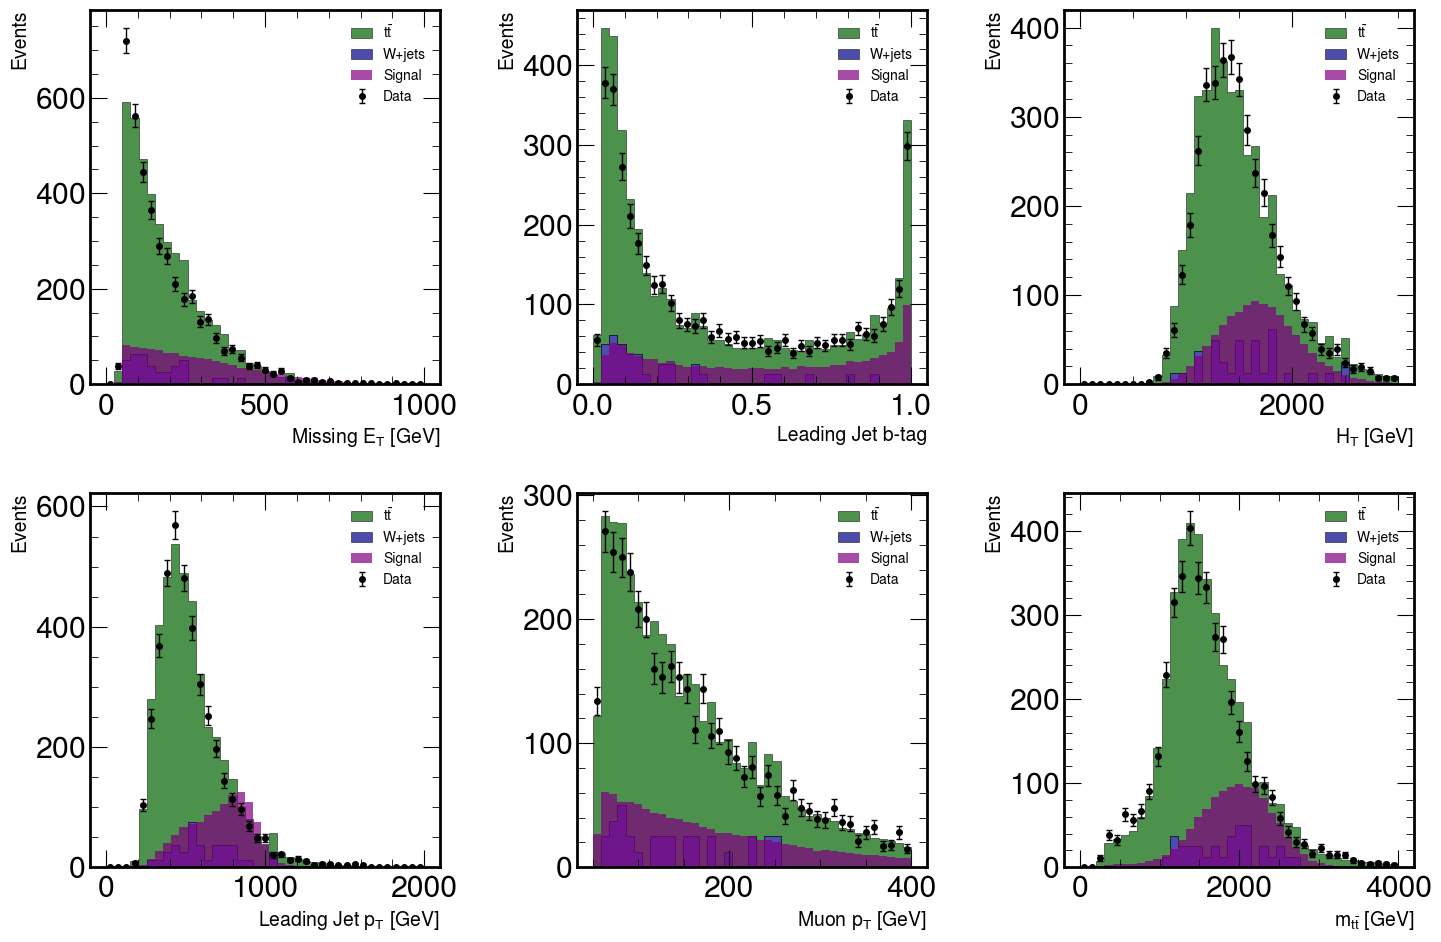

In [86]:
# Use the CMS plotting style
hep.style.use("CMS")

# Plot some key distributions for data vs MC
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

features_to_plot = [
    ('met_pt', r'Missing $E_T$ [GeV]', jnp.linspace(0, 1000, 40)),
    ('leading_jet_btag', 'Leading Jet b-tag', jnp.linspace(0, 1, 40)),
    ('st', r'$H_T$ [GeV]', jnp.linspace(0, 3000, 40)),
    ('leading_jet_pt', 'Leading Jet $p_T$ [GeV]', jnp.linspace(0, 2000, 40)),
    ('muon_pt', r'Muon $p_T$ [GeV]', jnp.linspace(50, 400, 40)),
    ('m_ttbar', r'$m_{t\bar{t}}$ [GeV]', jnp.linspace(0, 4000, 40)),
]

for ax, (feature, label, bins) in zip(axes, features_to_plot):
    # Stack MC backgrounds manually
    wjets_hist, _ = jnp.histogram(wjets_data[feature], bins=bins, weights=wjets_weights)
    ttbar_hist, _ = jnp.histogram(ttbar_data[feature], bins=bins, weights=ttbar_weights)

    hep.histplot(
        [wjets_hist, ttbar_hist],
        bins=bins,
        stack=True,
        ax=ax,
        label=['W+jets', r't$\bar{t}$'],
        color=['darkblue', 'darkgreen'],
        edgecolor='black',
        histtype='fill',
        linewidth=0.5,
        alpha=0.7
    )

    # Signal overlay
    signal_hist, _ = jnp.histogram(signal_data[feature], bins=bins, weights=signal_weights)
    hep.histplot(
        signal_hist,
        bins=bins,
        ax=ax,
        label="Signal",
        histtype='fill',
        linewidth=2,
        color='purple',
        alpha=0.7
    )

    # Data points
    data_counts, _ = jnp.histogram(data_obs[feature], bins=bins)
    bin_centers = (bins[:-1] + bins[1:]) / 2 if not isinstance(bins, range) else np.array(list(bins))[:-1] + 0.5

    ax.errorbar(
        bin_centers, data_counts,
        yerr=jnp.sqrt(data_counts),
        fmt='o', color='black',
        markersize=4, capsize=2,
        label='Data', linewidth=1
    )

    ax.set_xlabel(label, fontsize=14)
    ax.set_ylabel('Events', fontsize=14)
    ax.legend(fontsize=10, frameon=False)
    ax.set_ylim(bottom=0)
    # Use scientific notation in LaTeX style
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-3, 3))  # Force scientific notation outside this range

    ax.yaxis.set_major_formatter(formatter)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-3, 3))

plt.tight_layout()
plt.show()

## Part 3: Differentiable Cuts

**What you know**: Selection cuts filter events (e.g., MET > 100 GeV → accept/reject)

**What's new**: Soft cuts use sigmoid functions → smooth transition from 0 to 1

**Why it matters**: Smooth = differentiable → we can compute ∂(efficiency)/∂(cut threshold)

### Soft Selection with Sigmoid

A relaxed cut is turned into a continous one by applying a weight to each event based on the sigmoid function:

$$
w_{\text{soft}} = \sigma\left(\frac{x - \text{threshold}}{T}\right) = \frac{1}{1 + e^{-(x - \text{threshold})/T}}
$$

where $T$ is the temperature (controls smoothness).

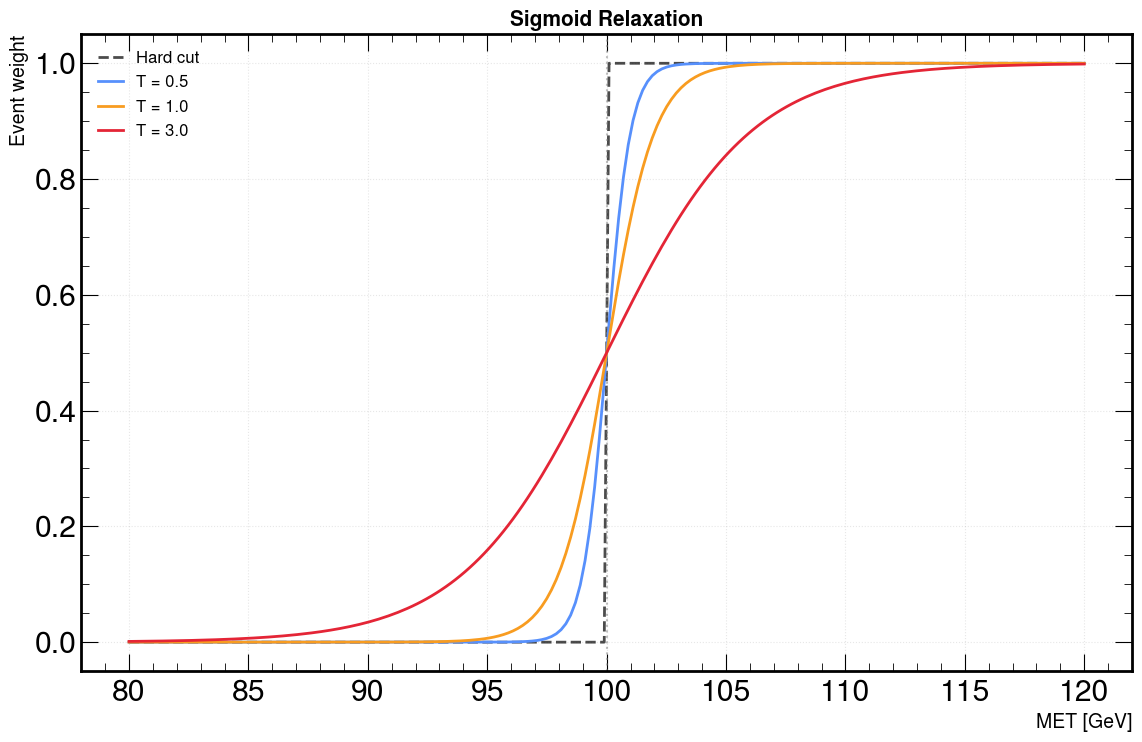

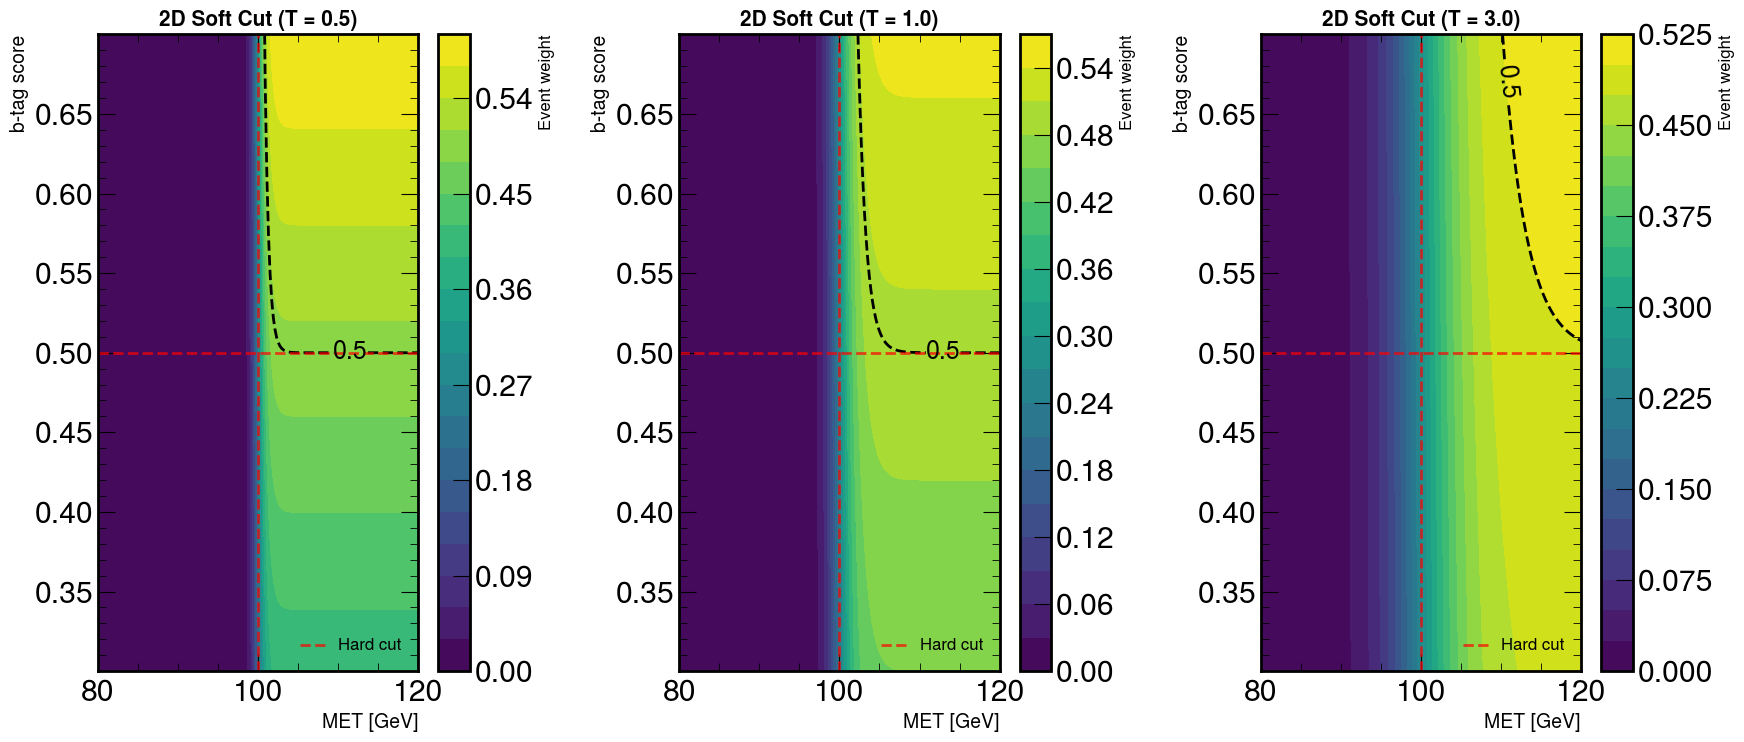

✓ Soft cuts provide smooth, differentiable transitions


In [ ]:
# Try to tweak and see how plots change
MET_THR  = 100.0       # initial MET cut threshold
BTAG_THR = 0.5         # initial b-tag cut threshold
TEMPS    = [0.5, 1.0, 3.0]   # temperatures to compare
GRID_N   = 200         # mesh resolution for 2D plots

def sigmoid(x, thr, T):
    """Smooth (differentiable) step function with slope controlled by T."""
    return 1 / (1 + jnp.exp(-(x - thr) / T))


# --------------------------------------------------------------------
# 1D visualization: sigmoid relaxation vs. hard cut
# --------------------------------------------------------------------
x = jnp.linspace(80, 120, 200)
step = (x > MET_THR).astype(float)

fig, ax1 = plt.subplots(figsize=(12, 8))

# Hard cut (step)
ax1.plot(x, step, 'k--', linewidth=2, alpha=0.7, label='Hard cut')
ax1.axvline(MET_THR, color='gray', linestyle=':', alpha=0.5)

# Sigmoid relaxations
for T in TEMPS:
    ax1.plot(x, sigmoid(x, MET_THR, T), linewidth=2, label=f'T = {T}')

ax1.set_xlabel('MET [GeV]', fontsize=14)
ax1.set_ylabel('Event weight', fontsize=14)
ax1.set_title('Sigmoid Relaxation', fontsize=15, fontweight='bold')
ax1.legend(fontsize=12, frameon=False)
ax1.grid(alpha=0.3)
fig.tight_layout()


# --------------------------------------------------------------------
# 2D visualization: smooth soft-cut boundaries
# --------------------------------------------------------------------
met_vals  = jnp.linspace(80, 120, GRID_N)
btag_vals = jnp.linspace(0.3, 0.7, GRID_N)
MET, BTAG = jnp.meshgrid(met_vals, btag_vals)

fig2, axs = plt.subplots(1, len(TEMPS), figsize=(18, 8))

for idx, T in enumerate(TEMPS):
    ax = axs[idx]

    # Combined soft weights (product of sigmoids)
    w_met  = sigmoid(MET, MET_THR, T)
    w_btag = sigmoid(BTAG, BTAG_THR, T)
    w = w_met * w_btag

    # Filled contours
    im = ax.contourf(MET, BTAG, w, levels=20, cmap='viridis')

    # Black contour = smooth boundary where weight = 0.5
    cs = ax.contour(MET, BTAG, w, levels=[0.5], colors='black', linewidths=2, linestyles='--')
    ax.clabel(cs, fmt='0.5', colors='black', fontsize=18)

    # Hard cut rectangle
    ax.axvline(MET_THR, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Hard cut')
    ax.axhline(BTAG_THR, color='red', linestyle='--', linewidth=2, alpha=0.7)

    ax.set_xlabel('MET [GeV]', fontsize=14)
    ax.set_ylabel('b-tag score', fontsize=14)
    ax.set_title(f'2D Soft Cut (T = {T})', fontsize=15, fontweight='bold')

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Event weight', fontsize=12)
    ax.legend(fontsize=12, frameon=False, loc='lower right')

fig2.tight_layout()
plt.show()

## Part 4: Differentiable histograms with binned KDEs

**What you know**: Histograms bin data into discrete bins

**What's new**: Binned KDE uses Gaussian CDF = smooth, differentiable histograms

**Why it matters**: We can compute ∂(histogram)/∂(bin edges) and ∂(histogram)/∂(bandwidth)!

### Binned KDE formula

Instead of hard binning, we use Gaussian CDFs:

$$
h_i = \sum_{j=1}^{N} w_j \left[ \Phi\left(\frac{e_{i+1} - x_j}{\sigma}\right) - \Phi\left(\frac{e_i - x_j}{\sigma}\right) \right]
$$

where $\Phi$ is the Gaussian CDF, $e_i$ are the bin edges, $w_j$ are event weights, and $\sigma$ is the bandwidth.

This is **fully differentiable** w.r.t. both data and bin edges!

### Defining a differentiable histogram

In [89]:
def binned_kde_histogram(values, weights, bin_edges, bandwidth):
    """
    Differentiable histogram using Kernel Density Estimation.

    Parameters:
    -----------
    values : array
        Event values (e.g., MET, jet pT)
    weights : array
        Event weights
    bin_edges : array
        Histogram bin edges
    bandwidth : float
        KDE bandwidth (smoothing parameter)

    Returns:
    --------
    array : Histogram bin contents
    """
    # Compute CDF at each bin edge for each event
    cdf = jax.scipy.stats.norm.cdf(
        bin_edges.reshape(-1, 1),  # Shape: (n_bins+1, 1)
        loc=values.reshape(1, -1),  # Shape: (1, n_events)
        scale=bandwidth,
    )

    # Weight the CDF
    weighted_cdf = cdf * weights.reshape(1, -1)

    # Bin content = difference between successive bin edges
    bin_weights = weighted_cdf[1:, :] - weighted_cdf[:-1, :]
    histogram = jnp.sum(bin_weights, axis=1)

    return histogram

# JIT compile for speed
binned_kde_histogram_jit = jit(binned_kde_histogram)

### Comparing bKDEs with regular histograms

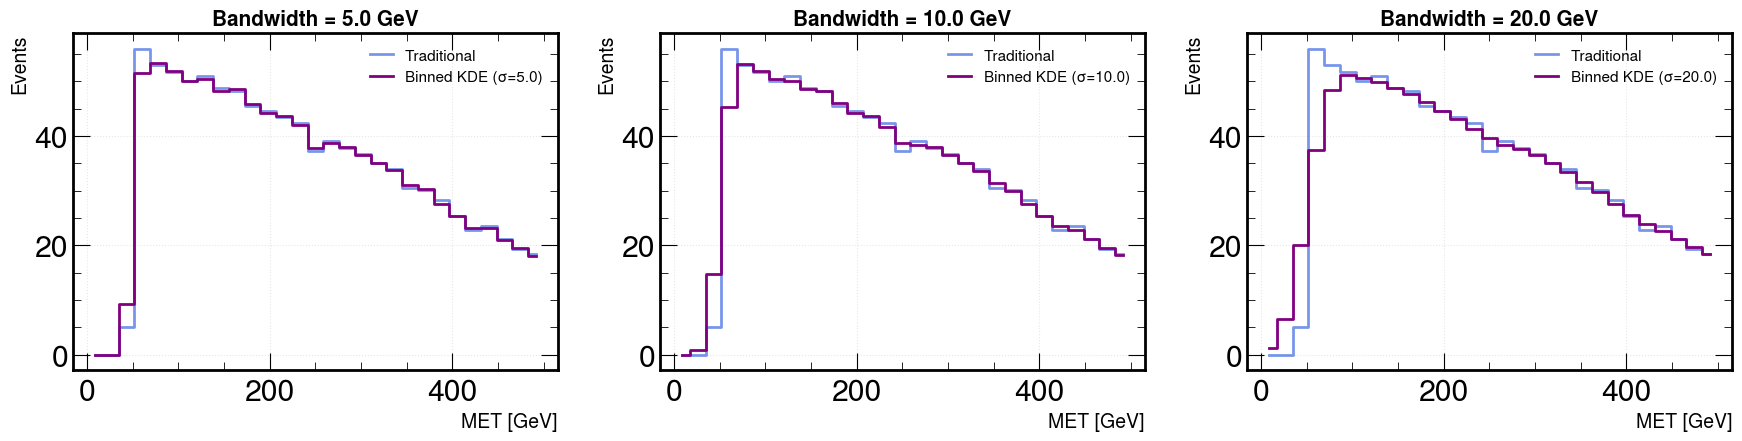

Smaller bandwidth → closer to hard histogram
Larger bandwidth → smoother, but loses resolution


In [96]:
# We do this for the signal process and the MET distribution
signal_met_values = signal_data['met_pt']

# Tweak these parameters and see how the plots change!
bin_edges = jnp.linspace(0, 500, 30)
bandwidths = [5.0, 10.0, 20.0]

# Make plots for different bandwidths
fig, axes = plt.subplots(1, len(bandwidths), figsize=(18, 5))
# Traditional histogram (non-differentiable)
hist_trad, _ = jnp.histogram(signal_met_values, bins=bin_edges, weights=signal_w)

for ax, bandwidth in zip(axes, bandwidths):
    # Binned KDE histogram (differentiable)
    hist_kde = binned_kde_histogram_jit(signal_met_values, signal_w, bin_edges, bandwidth)

    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Plot both
    ax.step(bin_centers, hist_trad, where='mid', color='royalblue',
            linewidth=2, alpha=0.7, label='Traditional')
    ax.step(bin_centers, hist_kde, where='mid', color='purple',
            linewidth=2, label=f'Binned KDE (σ={bandwidth})')

    ax.set_xlabel('MET [GeV]', fontsize=14)
    ax.set_ylabel('Events', fontsize=14)
    ax.set_title(f'Bandwidth = {bandwidth} GeV', fontsize=15, fontweight='bold')
    ax.legend(fontsize=11, frameon=False)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('binned_kde_comparison.pdf', dpi=150, bbox_inches='tight')
plt.show()

console.print("Smaller bandwidth → closer to hard histogram")
console.print("Larger bandwidth → smoother, but loses resolution")

### Gradient flow through histograms

Key advantage: we can compute **gradients** through the histogram!

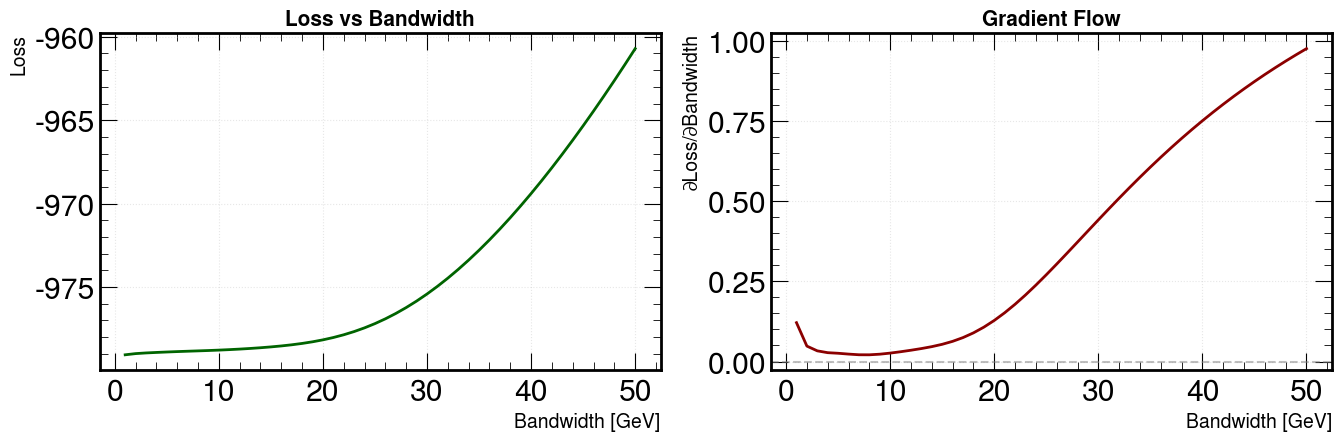

In [99]:
# Define a dummy loss function that depends on histogram
def histogram_loss(bandwidth, values, weights, bin_edges):
    """Loss = negative total histogram content (demo only)."""
    hist = binned_kde_histogram(values, weights, bin_edges, bandwidth)
    return -jnp.sum(hist)

# Compute gradient w.r.t. bandwidth with jax
grad_fn_hist = jax.grad(histogram_loss, argnums=0) # argnums=0 means we take gradient w.r.t. first argument

# Test gradients at different bandwidths
test_bandwidths = jnp.linspace(1.0, 50.0, 50)
gradients = []
losses = []

for bw in test_bandwidths:
    loss = histogram_loss(bw, signal_values, signal_w, bin_edges)
    grad = grad_fn_hist(bw, signal_values, signal_w, bin_edges)
    gradients.append(float(grad))
    losses.append(float(loss))

# Plot gradient flow
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(test_bandwidths, losses, linewidth=2, color='darkgreen')
ax1.set_xlabel('Bandwidth [GeV]', fontsize=14)
ax1.set_ylabel('Loss', fontsize=14)
ax1.set_title('Loss vs Bandwidth', fontsize=15, fontweight='bold')
ax1.grid(alpha=0.3)

ax2.plot(test_bandwidths, gradients, linewidth=2, color='darkred')
ax2.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax2.set_xlabel('Bandwidth [GeV]', fontsize=14)
ax2.set_ylabel('∂Loss/∂Bandwidth', fontsize=14)
ax2.set_title('Gradient Flow', fontsize=15, fontweight='bold')
ax2.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### Putting soft cuts and bKDEs together

In [100]:
def build_hist_with_cuts(data_dict, opt_params, bin_edges, temperature=0.1):
    """
    Build binned KDE histogram with soft cuts applied.

    Parameters
    ----------
    data_dict : dict
        Data dictionary with JAX arrays
    opt_params : dict
        Optimization parameters:
        - met_cut, btag_cut, ht_cut (selection cuts)
        - bandwidth (histogram smoothing)
    bin_edges : array
        Histogram bin edges
    temperature : float
        Soft cut temperature

    Returns
    -------
    hist : array
        Differentiable histogram
    """
    # Extract m_ttbar values and weights (already JAX arrays from Part 2!)
    values = data_dict['m_ttbar']
    weights = data_dict['weight']

    # Apply soft selection (uses cut parameters)
    met_pass = jax.nn.sigmoid((data_dict['met_pt'] - opt_params['met_cut']) / temperature)
    btag_pass = jax.nn.sigmoid((data_dict['leading_jet_btag'] - opt_params['btag_cut']) / temperature)
    ht_pass = jax.nn.sigmoid((data_dict['st'] - opt_params['ht_cut']) / temperature)
    selection_weights = met_pass * btag_pass * ht_pass

    final_weights = weights * selection_weights

    # Binned KDE (uses bandwidth parameter)
    bandwidth = opt_params['bandwidth']

    # Use binned_kde_histogram funciton from earlier
    histogram = binned_kde_histogram(values, final_weights, bin_edges, bandwidth)

    return histogram

## Part 5: Statistical Significance with evermore

[evermore](https://github.com/pfackeldey/evermore) gives us fit model primitives that are written in pure jax, and hence fully differentiable! Check out [the talk on evermore](https://indico.cern.ch/event/1566263/timetable/#23-evermore-differentiable-bin) in this workshop.

### Our simple model
We use a simple model where we fit the $t\bar{t}$ invariant mass ($m_{t\bar{t}}$) distribution to data, allowing only the signal and $t\bar{t}$ normalization to float. We only use a Poisson PDF term in the likelihood, and minimize the negative log-likelihood. 

In [101]:

# Initial optimization parameters
# Includes both CUTS (MET, b-tag, HT) and histogram settings (bandwidth)
initial_params = {
    'met_cut': jnp.array(50.0),      # MET threshold [GeV]
    'btag_cut': jnp.array(0.5),      # b-tagging score threshold
    'ht_cut': jnp.array(600.0),      # HT threshold [GeV]
    'bandwidth': jnp.array(40.0),    # KDE smoothing parameter [GeV]
}

# Define m_ttbar bins for fit
m_ttbar_bins = jnp.linspace(500, 3500, 15)  # 14 bins in ttbar mass

console.print("[cyan]Initial optimization parameters:[/cyan]")
console.print(f"  MET cut: {initial_params['met_cut']:.1f} GeV")
console.print(f"  b-tag cut: {initial_params['btag_cut']:.2f}")
console.print(f"  HT cut: {initial_params['ht_cut']:.1f} GeV")
console.print(f"  Bandwidth: {initial_params['bandwidth']:.1f} GeV")

Initial optimization parameters:
  MET cut: 50.0 GeV
  b-tag cut: 0.50
  HT cut: 600.0 GeV


  Bandwidth: 40.0 GeV


In [ ]:
import evermore as evm

def statistical_model(params, templates):
    """Apply scaling modifiers to templates."""
    signal_scaled = params["mu"].scale()(templates["signal"])
    ttbar_scaled = params["scale_ttbar"].scale()(templates["ttbar"])
    wjets_unscaled = templates["wjets"]
    return signal_scaled + ttbar_scaled + wjets_unscaled

def poisson_nll(params, templates, observation):
    """Poisson negative log-likelihood."""
    expected = statistical_model(params, templates)
    log_likelihood = evm.pdf.PoissonContinuous(lamb=expected).log_prob(observation).sum()

    # Parameter constraints
    constraints = evm.loss.get_log_probs(params)
    constraints = jax.tree.map(jnp.sum, constraints)
    log_likelihood += evm.util.sum_over_leaves(constraints)

    return -log_likelihood

### Profile likelihood ratio test

Test statistic for discovery:
$$
q_0 = -2\ln\frac{L(\mu=0, \hat{\hat{\theta}})}{L(\hat{\mu}, \hat{\theta})}
$$

Significance: $Z = \Phi^{-1}(1 - p)$ where $p = 1 - \Phi(\sqrt{q_0})$

**Key insight**: We can compute $\frac{\partial Z}{\partial \theta_{\text{cut}}}$ → enables gradient-based optimization!

We demonstrate here the use of `optimistix` to perform the fit. `optimistix` is a library providing a range of optimization solvers.

In [ ]:
import optimistix as optx

def compute_evermore_significance(opt_params, wjets_dict, ttbar_dict, signal_dict, data_dict):
    """
    Compute discovery significance using evermore. This is our objective function
    which wraps the differentiable part of our analysis. It recieves a dictionary
    of optimizable parameters and returns the objective (significance) which we optimize
    with respect to.

    Returns
    -------
    Z : float
        Discovery significance (σ)
    (mu_hat, kappa_hat) : tuple(float, float)
        Best-fit parameters:
         - mu_hat : float
            Best-fit signal strength
         - kappa_hat : float
            Best-fit ttbar normalization
    """
    # Build histograms using our building block
    signal_hist = build_hist_with_cuts(signal_dict, opt_params, m_ttbar_bins)
    ttbar_hist = build_hist_with_cuts(ttbar_dict, opt_params, m_ttbar_bins)
    wjets_hist = build_hist_with_cuts(wjets_dict, opt_params, m_ttbar_bins)
    data_hist = build_hist_with_cuts(data_dict, opt_params, m_ttbar_bins)

    # Create initial evermore parameters
    evm_params = {
        "mu": evm.Parameter(value=1.0, name="mu"),
        "scale_ttbar": evm.Parameter(value=1.0, name="scale_ttbar"),
    }

    params = {
        "mu": evm.Parameter(value=1.0, name="mu"),
        "kappa_ttbar": evm.Parameter(value=1.0, name="kappa_ttbar"),
    }

    # Build templates dictionary
    hists = {
        "signal": signal_hist,
        "ttbar": ttbar_hist,
        "wjets": wjets_hist,
    }

    # Apply modifiers (scaling)
    def model(params, hists):
        out = {}
        # Signal: scale by mu
        modifier_signal = evm.modifier.Compose(*[params["mu"].scale()])
        out["signal"] = modifier_signal(hists["signal"])

        # ttbar: scale by kappa_ttbar
        modifier_ttbar = evm.modifier.Compose(*[params["kappa_ttbar"].scale()])
        out["ttbar"] = modifier_ttbar(hists["ttbar"])

        # W+jets: no scaling
        out["wjets"] = hists["wjets"]

        return out

    # Compute loss (negative log likelihood)
    def loss(params):
        expected = evm.util.sum_over_leaves(model(params, hists))
        log_likelihood = evm.pdf.PoissonContinuous(lamb=expected).log_prob(data_hist).sum()
        # Add parameter constraints (if any)
        constraints = evm.loss.get_log_probs(params)
        constraints = jax.tree.map(jnp.sum, constraints)
        log_likelihood += evm.util.sum_over_leaves(constraints)
        return -jnp.sum(log_likelihood)


    def optx_loss(dynamic, args):
        """
        Optimistix-compatible loss function. Optimistix requires the
        parameters to be passed as the first argument and an iterable
        of further arguments as the second argument.
        Parameters
        ----------
        dynamic : dict
            Dynamic (to be optimized) parameters
        args : tuple
            Further arguments (e.g. static parameters)
        Returns
        -------
        float
            Loss value
        """
        static, = args
        # Combine dynamic and static parameters to pass to loss function
        params_combined = evm.tree.combine(dynamic, static)
        return loss(params_combined)

    # -------------------------------------------------------------------------
    # Perform an unconditional fit using optimistix with mu and kappa_ttbar free
    # -------------------------------------------------------------------------
    solver = optx.BFGS(rtol=1e-4, atol=1e-6)

    # Partition parameters into dynamic (to be optimized) and static (fixed)
    dynamic, static = evm.tree.partition(params, filter=evm.filter.is_not_frozen)

    # Get fit results
    fitresult = optx.minimise(
        optx_loss,
        solver,
        dynamic,
        args=(static,),
        max_steps=100,
    )

    # Extract best-fit parameters and NLL
    bestfit_params = evm.tree.combine(fitresult.value, static)
    nll = loss(bestfit_params)

    # Get best-fit parameter values
    mu_hat = bestfit_params["mu"].value
    kappa_hat = bestfit_params["kappa_ttbar"].value

    # -----------------------------------------------------------------------------
    # Perform a conditional fit using optimistix with mu fixed and kappa_ttbar free
    # -----------------------------------------------------------------------------
    params_null = {
        "mu": evm.Parameter(value=0.0, name="mu", frozen=True),
        "kappa_ttbar": evm.Parameter(value=kappa_hat, name="kappa_ttbar"),
    }

    dynamic_null, static_null = evm.tree.partition(params_null, filter=evm.filter.is_not_frozen)

    fitresult_null = optx.minimise(
        optx_loss,
        solver,
        dynamic_null,
        args=(static_null,),
        max_steps=100,
    )

    bestfit_params_null = evm.tree.combine(fitresult_null.value, static_null)
    nll_null = loss(bestfit_params_null)

    # -------------------------------------------------------------------------
    # Compute test statistic q0 and discovery significance Z
    # -------------------------------------------------------------------------
    likelihood_ratio = 2.0 * (nll_null - nll)
    q0 = jnp.where(mu_hat >= 0.0, likelihood_ratio, 0.0)
    # Discovery significance
    Z = jnp.sqrt(q0)

    # Return significance and best-fit parameters
    # jax.grad requires returning the objective first, then a tuple of auxiliary values
    return Z, (mu_hat, kappa_hat)


### Computing the initial significance and summary of initial parameter values

In [105]:
console.print("[cyan]Computing initial significance with evermore...[/cyan]")

# Compute significance with initial parameters
Z_initial, (mu_initial, kappa_initial) = compute_evermore_significance(initial_params, wjets_jax, ttbar_jax, signal_jax, data_jax)

console.print(f"\n[yellow]Initial significance: {Z_initial:.2f}σ[/yellow]")
console.print(f"MET cut: {initial_params['met_cut']:.1f} GeV")
console.print(f"b-tag cut: {initial_params['btag_cut']:.2f}")
console.print(f"HT cut: {initial_params['ht_cut']:.1f} GeV")
console.print(f"Bandwidth: {initial_params['bandwidth']:.1f} GeV")

Computing initial significance with evermore...

Initial significance: 1.34σ
MET cut: 50.0 GeV
b-tag cut: 0.50
HT cut: 600.0 GeV
Bandwidth: 40.0 GeV


### Computing gradients of significance with respect to everything!

In [107]:
# Get the gradient function and decalre that it produces auxiliary values
grad_fn = jax.grad(lambda params: compute_evermore_significance(params, wjets_jax, ttbar_jax, signal_jax, data_jax), has_aux=True)
# Compute gradients
grads, _ = grad_fn(initial_params)

console.print(f"\n[cyan]Gradients of significance w.r.t. parameters:[/cyan]")
console.print(f"  ∂Z/∂(MET cut) = {grads['met_cut']:.4f}")
console.print(f"  ∂Z/∂(b-tag cut) = {grads['btag_cut']:.4f}")
console.print(f"  ∂Z/∂(HT cut) = {grads['ht_cut']:.4f}")
console.print(f"  ∂Z/∂(bandwidth) = {grads['bandwidth']:.4f}")
console.print(f"\n[green]✓ Significance is differentiable![/green]")


Gradients of significance w.r.t. parameters:
  ∂Z/∂(MET cut) = 0.0254
  ∂Z/∂(b-tag cut) = 3.3169
  ∂Z/∂(HT cut) = -0.0000
  ∂Z/∂(bandwidth) = -0.0004

✓ Significance is differentiable!


## Part 6: Optimize with gradients

**What you know**: Optimize by trying many cut values (grid search, manual tuning)

**What's new**: Use gradients to automatically find optimal parameters to get best significance


### Gradient-based optimization

Since `compute_evermore_significance` is differentiable, we can use gradient ascent:

$$
\alpha^{(t+1)} = \alpha^{(t)} + \eta \nabla_{\theta} Z
$$

where $\alpha$ includes **all parameters**: MET cut, b-tag cut, HT cut, and bandwidth, and $\eta$ is a learning rate.

In [109]:
# Setup optimizer with per-parameter learning rates
optimizer = optax.multi_transform(
    {
        'met_cut': optax.adam(learning_rate=2.0),      # MET in GeV → larger steps
        'btag_cut': optax.adam(learning_rate=0.005),   # b-tag 0-1 → tiny steps
        'ht_cut': optax.adam(learning_rate=1.0),       # HT in GeV → moderate steps
        'bandwidth': optax.adam(learning_rate=1.0),    # Bandwidth in GeV → moderate steps
    },
    param_labels={p: p for p in initial_params.keys()}
)

# Initialize an optax optimizer (can also use optimisitix)
opt_state = optimizer.init(initial_params)
# Make a copy of the initial parameters to avoid changing them for later comparisons
params = initial_params.copy()

# A container to keep track of parameter histories for plotting
opt_history = {
    'met_cut': [],
    'btag_cut': [],
    'ht_cut': [],
    'bandwidth': [],
    'significance': [],
    'mu_hat': [],
    'kappa_hat': []
}

console.print("[cyan]Optimizing all parameters...[/cyan]")

# Optimization loop with set number of iterations
n_iterations = 20
for iteration in track(range(n_iterations), description="Optimizing"):
    # Compute significance and gradient
    sig, (mu_hat, kappa_hat) = compute_evermore_significance(params, wjets_jax, ttbar_jax, signal_jax, data_jax)
    grads, _= grad_fn(params)

    # Gradient ascent (maximize significance)
    grads = {k: -v for k, v in grads.items()}  # Negate for ascent

    # Update parameters
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

    # Track progress
    opt_history['met_cut'].append(float(params['met_cut']))
    opt_history['btag_cut'].append(float(params['btag_cut']))
    opt_history['ht_cut'].append(float(params['ht_cut']))
    opt_history['bandwidth'].append(float(params['bandwidth']))
    opt_history['significance'].append(float(sig))
    opt_history['mu_hat'].append(float(mu_hat))
    opt_history['kappa_hat'].append(float(kappa_hat))


final_sig = opt_history['significance'][-1]
mu_final = opt_history['mu_hat'][-1]
kappa_final = opt_history['kappa_hat'][-1]
console.print(f"\n[green]✓ Optimization complete![/green]")
console.print(f"  Initial: {Z_initial:.2f}σ → Final: {final_sig:.2f}σ")
console.print(f"  MET cut: {initial_params['met_cut']:.1f} → {params['met_cut']:.1f} GeV")
console.print(f"  b-tag cut: {initial_params['btag_cut']:.2f} → {params['btag_cut']:.2f}")
console.print(f"  HT cut: {initial_params['ht_cut']:.1f} → {params['ht_cut']:.1f} GeV")
console.print(f"  Bandwidth: {initial_params['bandwidth']:.1f} → {params['bandwidth']:.1f} GeV")

Optimizing all parameters...


Output()


✓ Optimization complete!
  Initial: 1.34σ → Final: 1.65σ
  MET cut: 50.0 → 52.6 GeV
  b-tag cut: 0.50 → 0.60
  HT cut: 600.0 → 600.0 GeV
  Bandwidth: 40.0 → 38.3 GeV


### Make plots of parameter histories

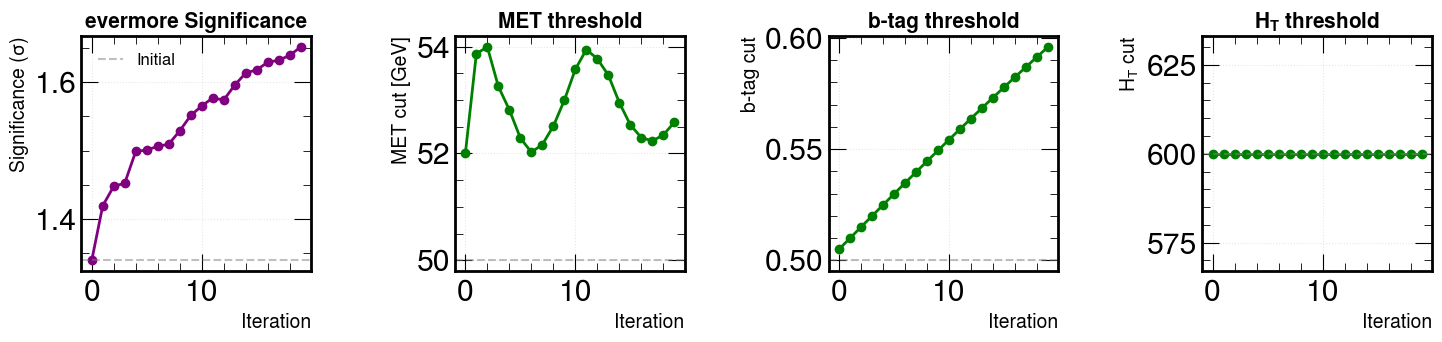

✓ Optimized statistical significance with gradients!


In [111]:
# Visualize optimization
fig, axes = plt.subplots(1, 4, figsize=(15, 4))

# Significance
axes[0].plot(opt_history['significance'], linewidth=2, color='purple', marker='o')
axes[0].axhline(float(Z_initial), color='gray', linestyle='--', alpha=0.5, label='Initial')
axes[0].set_xlabel('Iteration', fontsize=14)
axes[0].set_ylabel('Significance (σ)', fontsize=14)
axes[0].set_title('evermore Significance', fontsize=15, fontweight='bold')
axes[0].legend(fontsize=12)
axes[0].grid(alpha=0.3)

# MET cut
axes[1].plot(opt_history['met_cut'], linewidth=2, color='green', marker='o')
axes[1].axhline(float(initial_params['met_cut']), color='gray', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Iteration', fontsize=14)
axes[1].set_ylabel('MET cut [GeV]', fontsize=14)
axes[1].set_title('MET threshold', fontsize=15, fontweight='bold')
axes[1].grid(alpha=0.3)

# b-tag cut
axes[2].plot(opt_history['btag_cut'], linewidth=2, color='green', marker='o')
axes[2].axhline(float(initial_params['btag_cut']), color='gray', linestyle='--', alpha=0.5)
axes[2].set_xlabel('Iteration', fontsize=14)
axes[2].set_ylabel('b-tag cut', fontsize=14)
axes[2].set_title('b-tag threshold', fontsize=15, fontweight='bold')
axes[2].grid(alpha=0.3)

# HT cut
axes[3].plot(opt_history['ht_cut'], linewidth=2, color='green', marker='o')
axes[3].axhline(float(initial_params['ht_cut']), color='gray', linestyle='--', alpha=0.5)
axes[3].set_xlabel('Iteration', fontsize=14)
axes[3].set_ylabel(r'$H_T$ cut', fontsize=14)
axes[3].set_title(r'$H_T$ threshold', fontsize=15, fontweight='bold')
axes[3].grid(alpha=0.3)

plt.tight_layout()
plt.show()

console.print("[green]✓ Optimized statistical significance with gradients![/green]")

## Part 7: Complete workflow

**Putting it all together**:

1. **Soft Cuts** → differentiable selection
2. **Binned KDE** → differentiable histograms
3. **evermore** → differentiable statistical significance
4. **Gradients** → optimize everything end-to-end!

This is the full **GRAEP** (Gradient-based Analysis Optimization) pipeline in the slides!

In [112]:
from rich.table import Table
from rich.panel import Panel

# Summary of the complete workflow
workflow_text = """
[cyan]1. Soft Selection[/cyan]
   Apply differentiable cuts with sigmoid functions
   ↓
[cyan]2. Binned KDE Histograms[/cyan]
   Build smooth, differentiable histograms
   ↓
[cyan]3. evermore Statistical Model[/cyan]
   Profile likelihood with Poisson statistics
   ↓
[cyan]4. Gradient Optimization[/cyan]
   Maximize discovery significance
"""

panel = Panel(workflow_text, title="[bold]GRAEP Workflow[/bold]", border_style="green")
console.print(panel)

# Show optimization results
table = Table(title="Optimization Results", show_header=True, header_style="bold cyan")
table.add_column("Parameter", style="cyan", width=20)
table.add_column("Initial", justify="right", style="white")
table.add_column("Optimized", justify="right", style="yellow")
table.add_column("Change", justify="right", style="green")

met_change = float(params['met_cut'] - initial_params['met_cut'])
btag_change = float(params['btag_cut'] - initial_params['btag_cut'])
ht_change = float(params['ht_cut'] - initial_params['ht_cut'])
bandwidth_change = float(params['bandwidth'] - initial_params['bandwidth'])
sig_change = final_sig - float(Z_initial)

table.add_row(
    "MET cut [GeV]",
    f"{float(initial_params['met_cut']):.1f}",
    f"{float(params['met_cut']):.1f}",
    f"{met_change:+.1f}"
)
table.add_row(
    "b-tag cut",
    f"{float(initial_params['btag_cut']):.2f}",
    f"{float(params['btag_cut']):.2f}",
    f"{btag_change:+.3f}"
)
table.add_row(
    "HT cut",
    f"{float(initial_params['ht_cut']):.2f}",
    f"{float(params['ht_cut']):.2f}",
    f"{ht_change:+.3f}"
)
table.add_row(
    "bKDE bandwidth",
    f"{float(initial_params['bandwidth']):.2f}",
    f"{float(params['bandwidth']):.2f}",
    f"{bandwidth_change:+.3f}"
)
table.add_row(
    "Significance [σ]",
    f"{float(Z_initial):.2f}",
    f"{final_sig:.2f}",
    f"{sig_change:+.2f}"
)

console.print(table)
console.print("\n[green]✓ Complete differentiable analysis workflow![/green]")

╭─────────────────────────────── GRAEP Workflow ───────────────────────────────╮
│                                                                              │
│ 1. Soft Selection                                                            │
│    Apply differentiable cuts with sigmoid functions                          │
│    ↓                                                                         │
│ 2. Binned KDE Histograms                                                     │
│    Build smooth, differentiable histograms                                   │
│    ↓                                                                         │
│ 3. evermore Statistical Model                                                │
│    Profile likelihood with Poisson statistics                                │
│    ↓                                                                         │
│ 4. Gradient Optimization                                                     │
│    Maximize discovery sign

### Plot fit results before and after holistic optimization

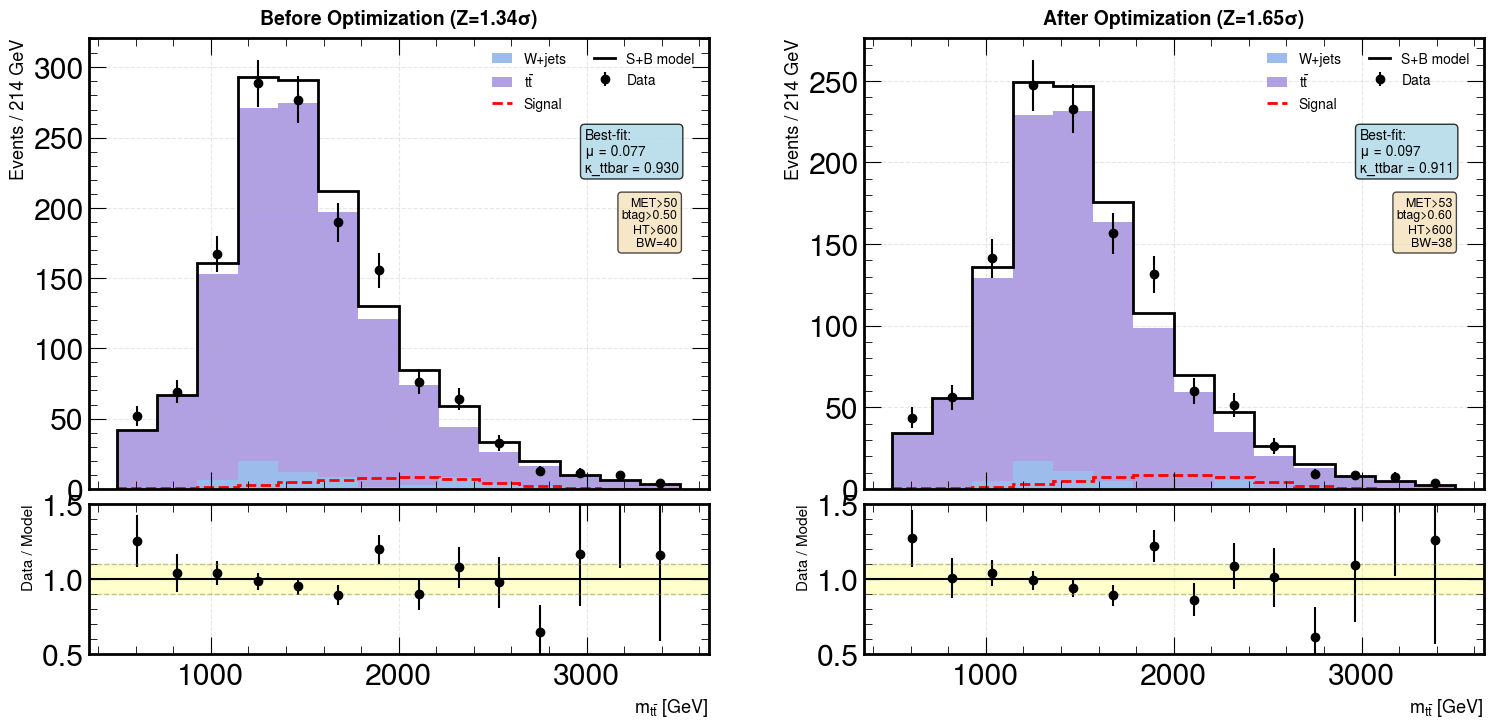

✓ Before/after comparison complete!
  Significance: 1.34σ → 1.65σ (23.3% improvement)
  Best-fit μ: 0.077 → 0.097
  Best-fit κ_ttbar: 0.930 → 0.911


In [114]:
import matplotlib.gridspec as gridspec

# Helper function to visualize fit with ratio panel
def plot_mttbar_with_fit(fig, gs, opt_params, mu_hat, kappa_hat, title, col_idx):
    """Plot m_ttbar distribution with evermore fit overlay and ratio panel."""
    # Build histograms with these parameters (using our building block!)
    signal_hist = build_hist_with_cuts(signal_jax, opt_params, m_ttbar_bins)
    ttbar_hist = build_hist_with_cuts(ttbar_jax, opt_params, m_ttbar_bins)
    wjets_hist = build_hist_with_cuts(wjets_jax, opt_params, m_ttbar_bins)
    data_hist = build_hist_with_cuts(data_jax, opt_params, m_ttbar_bins)

    # Apply best-fit normalizations
    wjets_fit = wjets_hist  # No modifier
    ttbar_fit = ttbar_hist * kappa_hat
    signal_fit = signal_hist * mu_hat
    total_model = wjets_fit + ttbar_fit + signal_fit

    bin_centers = (m_ttbar_bins[:-1] + m_ttbar_bins[1:]) / 2
    bin_width = m_ttbar_bins[1] - m_ttbar_bins[0]

    # Create main plot and ratio panel
    ax_main = fig.add_subplot(gs[0, col_idx])
    ax_ratio = fig.add_subplot(gs[1, col_idx], sharex=ax_main)

    # Main plot: Stacked backgrounds
    ax_main.stairs(wjets_fit, m_ttbar_bins, baseline=0, fill=True,
                   label='W+jets', color='#72A1E5', alpha=0.7, linewidth=0)
    ax_main.stairs(ttbar_fit, m_ttbar_bins, baseline=wjets_fit, fill=True,
                   label=r'$t\bar{t}$', color='#907AD6', alpha=0.7, linewidth=0)

    # Signal (scaled for visibility)
    ax_main.stairs(signal_fit, m_ttbar_bins, baseline=0,
                   label=f'Signal', color='red', linewidth=2, linestyle='--')

    # Total model
    ax_main.stairs(total_model, m_ttbar_bins, color='black',
                   linewidth=2, linestyle='-', label='S+B model', zorder=10)

    # Data points
    data_err = jnp.sqrt(data_hist)
    ax_main.errorbar(bin_centers, data_hist, yerr=data_err,
                     fmt='ko', label='Data', markersize=6, linewidth=1.5, zorder=15)

    ax_main.set_ylabel('Events / {:.0f} GeV'.format(bin_width), fontsize=13)
    ax_main.set_title(title, fontsize=14, fontweight='bold', pad=10)
    ax_main.legend(fontsize=10, ncol=2, loc='upper right', frameon=False)
    ax_main.grid(alpha=0.3, linestyle='--')
    ax_main.tick_params(labelbottom=False)

    # Add fit results text
    fit_text = (f"Best-fit:\n"
                f"μ = {mu_hat:.3f}\n"
                f"κ_ttbar = {kappa_hat:.3f}")
    ax_main.text(0.8, 0.8, fit_text, transform=ax_main.transAxes,
                 fontsize=10, verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

    # Add parameter text
    param_text = (f"MET>{opt_params['met_cut']:.0f}\n"
                  f"btag>{opt_params['btag_cut']:.2f}\n"
                  f"HT>{opt_params['ht_cut']:.0f}\n"
                  f"BW={opt_params['bandwidth']:.0f}")
    ax_main.text(0.95, 0.65, param_text, transform=ax_main.transAxes,
                 fontsize=9, verticalalignment='top', horizontalalignment='right',
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

    # Ratio panel: Data / Model
    ratio = jnp.where(total_model > 0, data_hist / total_model, 1.0)
    ratio_err = jnp.where(total_model > 0, data_err / total_model, 0.0)

    ax_ratio.errorbar(bin_centers, ratio, yerr=ratio_err,
                      fmt='ko', markersize=6, linewidth=1.5)
    ax_ratio.axhline(1, color='black', linestyle='-', linewidth=1.5)
    ax_ratio.axhline(1.1, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    ax_ratio.axhline(0.9, color='gray', linestyle='--', linewidth=1, alpha=0.5)

    ax_ratio.set_xlabel(r'$m_{t\bar{t}}$ [GeV]', fontsize=13)
    ax_ratio.set_ylabel('Data / Model', fontsize=11)
    ax_ratio.set_ylim(0.5, 1.5)
    ax_ratio.grid(alpha=0.3, linestyle='--')
    ax_ratio.axhspan(0.9, 1.1, alpha=0.2, color='yellow', zorder=0)


fig = plt.figure(figsize=(18, 8))
gs = gridspec.GridSpec(2, 2, height_ratios=[3, 1], hspace=0.05, wspace=0.25)

# Before optimization (use initial fit values)
plot_mttbar_with_fit(
    fig, gs, initial_params, mu_initial, kappa_initial,
    f'Before Optimization (Z={Z_initial:.2f}σ)', 0
)

# After optimization (use final fit values)
plot_mttbar_with_fit(
    fig, gs, params, mu_final, kappa_final,
    f'After Optimization (Z={final_sig:.2f}σ)', 1
)

plt.show()

console.print("[green]✓ Before/after comparison complete![/green]")
console.print(f"  Significance: {Z_initial:.2f}σ → {final_sig:.2f}σ ({((final_sig - Z_initial)/Z_initial*100):.1f}% improvement)")
console.print(f"  Best-fit μ: {mu_initial:.3f} → {mu_final:.3f}")
console.print(f"  Best-fit κ_ttbar: {kappa_initial:.3f} → {kappa_final:.3f}")

### Next Steps

**Try yourself:**
1. Add more cuts (`st`, `S_zz`, `min_deltaR_mu_jet`)
2. Experiment with temperatures and learning rates
3. Explore MVA integration (see Appendix)

**Full GRAEP Framework:**
- NanoAOD processing pipeline
- Systematic uncertainties
- Profile likelihood fits
- CLs limit setting
- Multiple signal regions

**Resources:**
- 📚 [GRAEP Repository](https://github.com/iris-hep/GRAEP)
- 📖 [JAX Docs](https://jax.readthedocs.io/)
- 🔬 [CMS Open Data](https://opendata.cern.ch/)

---

# Appendix: MVA Integration (Advanced)

This section shows how to integrate neural networks into the differentiable workflow.

**Two approaches:**
1. Pre-train MVA, then optimize cuts
2. Joint optimization (GRAEP innovation)

**Note**: Core demo is complete without this.

In [117]:
# Define a simple 3-layer neural network in JAX
def init_network(key, input_dim=3, hidden_dim=16):
    """Initialize a small neural network."""
    keys = random.split(key, 6)

    W1 = random.normal(keys[0], (input_dim, hidden_dim)) * 0.1
    b1 = jnp.zeros(hidden_dim)

    W2 = random.normal(keys[2], (hidden_dim, hidden_dim)) * 0.1
    b2 = jnp.zeros(hidden_dim)

    W3 = random.normal(keys[4], (hidden_dim, 1)) * 0.1
    b3 = jnp.zeros(1)

    params = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3}
    n_params = sum(p.size for p in jax.tree.leaves(params))
    print(f"Network initialized: {n_params} parameters")
    return params

def forward(params, x):
    """Forward pass through the network."""
    h1 = jnp.tanh(jnp.dot(x, params['W1']) + params['b1'])
    h2 = jnp.tanh(jnp.dot(h1, params['W2']) + params['b2'])
    logits = jnp.dot(h2, params['W3']) + params['b3']
    return logits.squeeze()

def binary_cross_entropy_loss(params, x, y):
    """Binary cross-entropy loss."""
    logits = forward(params, x)
    # Numerically stable sigmoid + BCE
    return jnp.mean(jnp.maximum(logits, 0) - logits * y + jnp.log(1 + jnp.exp(-jnp.abs(logits))))

def accuracy(params, x, y):
    """Calculate classification accuracy."""
    logits = forward(params, x)
    predictions = (logits > 0).astype(jnp.float32)
    return jnp.mean(predictions == y)

@jit
def train_step(params, x, y, learning_rate=0.01):
    """Single gradient descent step (JIT-compiled for speed)."""
    loss, grads = jax.value_and_grad(binary_cross_entropy_loss)(params, x, y)
    updated_params = jax.tree.map(lambda p, g: p - learning_rate * g, params, grads)
    return updated_params, loss

In [118]:
# Train the MVA model
print("Training MVA model...")
key, subkey = random.split(key)
mva_params = init_network(subkey, input_dim=X_train.shape[1])

n_epochs = 100
learning_rate = 0.01
history = {'loss': [], 'train_acc': [], 'test_acc': []}

for epoch in range(n_epochs):
    mva_params, loss = train_step(mva_params, X_train, y_train, learning_rate)

    if epoch % 10 == 0:
        train_acc = accuracy(mva_params, X_train, y_train)
        test_acc = accuracy(mva_params, X_test, y_test)
        history['loss'].append(float(loss))
        history['train_acc'].append(float(train_acc))
        history['test_acc'].append(float(test_acc))
        print(f"Epoch {epoch:3d}: Loss={loss:.4f}, Train Acc={train_acc:.3f}, Test Acc={test_acc:.3f}")

final_test_acc = accuracy(mva_params, X_test, y_test)
print(f"\nFinal test accuracy: {final_test_acc:.3f}")
print("MVA training complete!")

Training MVA model...


NameError: name 'X_train' is not defined

In [119]:
# Visualize MVA scores
# Apply the model to all data
def get_mva_scores(data_dict, feature_names, scales):
    """Compute MVA scores for a dataset."""
    X = jnp.column_stack([data_dict[f] for f in feature_names]).astype(np.float32)
    for i, feat in enumerate(feature_names):
        X[:, i] /= scales[feat]
    return forward(mva_params, jnp.array(X))

wjets_scores = get_mva_scores(wjets_data, mva_features, feature_scales)
ttbar_scores = get_mva_scores(ttbar_data, mva_features, feature_scales)
signal_scores = get_mva_scores(signal_data, mva_features, feature_scales)

# Plot MVA score distributions WITH PROPER WEIGHTS
plt.figure(figsize=(10, 6))
# from min to max score
min_ = min(wjets_scores.min(), ttbar_scores.min(), signal_scores.min())
max_ = max(wjets_scores.max(), ttbar_scores.max(), signal_scores.max())
bins = jnp.linspace(min_, max_, 50)

# Use normalized weights (density=True for proper normalization)
plt.hist(wjets_scores, bins=bins, weights=wjets_weights_norm, alpha=0.5,
         label=f'W+jets (MC)', color='blue', edgecolor='black', linewidth=0.5, density=True)
plt.hist(ttbar_scores, bins=bins, weights=ttbar_weights_norm, alpha=0.5,
         label=f'ttbar (MC)', color='red', edgecolor='black', linewidth=0.5, density=True)
plt.hist(signal_scores, bins=bins, weights=signal_weights_norm, alpha=0.7,
         label=f'Signal (Z\' MC)', color='purple', histtype='step', linewidth=2, density=True)

plt.xlabel('MVA Score (W+jets vs ttbar discriminant)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('MVA Output: Background Discrimination (Weighted)', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.savefig('mva_scores.png', dpi=100, bbox_inches='tight')
plt.show()

print("Note: Higher MVA score → more ttbar-like (rejects W+jets background)")
print("Histograms now use proper MC weights for normalization!")

NameError: name 'mva_features' is not defined

### Option 1: Optimize Cuts with Pre-trained MVA

Now let's optimize three cuts: MET, b-tag, and MVA score threshold.

In [ ]:
# Note: compute_evermore_significance is defined in Part 5
# Here we show a simplified S/√B version for MVA case

# Update soft selection to include MVA cut
def soft_selection_with_mva(data_dict, mva_scores, params, temperature=5.0):
    """Apply soft cuts to data including MVA."""
    met_pass = sigmoid(data_dict['met_pt'] - params['met_cut'], temperature)
    btag_pass = sigmoid(data_dict['leading_jet_btag'] - params['btag_cut'], temperature)
    mva_pass = sigmoid(mva_scores - params['mva_cut'], temperature)

    # Combined event weight
    event_weights = met_pass * btag_pass * mva_pass
    return event_weights

def compute_significance_with_mva(cut_params, wjets_dict, ttbar_dict, signal_dict,
                                  wjets_mva, ttbar_mva, signal_mva, temperature=5.0):
    """Compute significance with MVA cut."""
    wjets_weights = soft_selection_with_mva(wjets_dict, wjets_mva, cut_params, temperature)
    ttbar_weights = soft_selection_with_mva(ttbar_dict, ttbar_mva, cut_params, temperature)
    signal_weights = soft_selection_with_mva(signal_dict, signal_mva, cut_params, temperature)

    n_signal = jnp.sum(signal_weights)
    n_background = jnp.sum(wjets_weights) + jnp.sum(ttbar_weights)

    significance = n_signal / jnp.sqrt(n_background + 1.0)
    return significance, n_signal, n_background

compute_significance_with_mva_jit = jit(compute_significance_with_mva, static_argnames=['temperature'])

# Initial cuts with MVA
mva_mean = float(jnp.mean(jnp.concatenate([wjets_scores, ttbar_scores])))
initial_cuts_mva = {
    'met_cut': jnp.array(100.0),
    'btag_cut': jnp.array(0.5),
    'mva_cut': jnp.array(mva_mean)
}

sig_mva_initial, s_mva, b_mva = compute_significance_with_mva_jit(
    initial_cuts_mva, wjets_jax, ttbar_jax, signal_jax,
    wjets_scores, ttbar_scores, signal_scores
)

print(f"Initial cuts with MVA: MET > {initial_cuts_mva['met_cut']:.1f}, b-tag > {initial_cuts_mva['btag_cut']:.2f}, MVA > {initial_cuts_mva['mva_cut']:.2f}")
print(f"  Signal: {s_mva:.1f}, Background: {b_mva:.1f}, Significance: {sig_mva_initial:.3f}")

In [ ]:
# Optimize all three cuts
def objective_with_mva(params):
    sig, _, _ = compute_significance_with_mva_jit(
        params, wjets_jax, ttbar_jax, signal_jax,
        wjets_scores, ttbar_scores, signal_scores
    )
    return -sig

grad_fn_mva = jax.grad(objective_with_mva)

# Optimize with per-parameter learning rates
per_param_lrs_mva = {
    'met_cut': 5.0,
    'btag_cut': 0.01,
    'mva_cut': 0.1
}

param_labels_mva = {p: p for p in initial_cuts_mva.keys()}

optimizer_mva = optax.multi_transform(
    {
        'met_cut': optax.adam(learning_rate=per_param_lrs_mva['met_cut']),
        'btag_cut': optax.adam(learning_rate=per_param_lrs_mva['btag_cut']),
        'mva_cut': optax.adam(learning_rate=per_param_lrs_mva['mva_cut']),
    },
    param_labels=param_labels_mva
)

opt_state_mva = optimizer_mva.init(initial_cuts_mva)
params_mva = initial_cuts_mva.copy()

opt_history_mva = {'met_cut': [], 'btag_cut': [], 'mva_cut': [], 'significance': []}

print("Optimizing with pre-trained MVA...")
n_iterations = 50
for iteration in range(n_iterations):
    grads = grad_fn_mva(params_mva)
    updates, opt_state_mva = optimizer_mva.update(grads, opt_state_mva)
    params_mva = optax.apply_updates(params_mva, updates)

    sig, s, b = compute_significance_with_mva_jit(
        params_mva, wjets_jax, ttbar_jax, signal_jax,
        wjets_scores, ttbar_scores, signal_scores
    )

    opt_history_mva['met_cut'].append(float(params_mva['met_cut']))
    opt_history_mva['btag_cut'].append(float(params_mva['btag_cut']))
    opt_history_mva['mva_cut'].append(float(params_mva['mva_cut']))
    opt_history_mva['significance'].append(float(sig))

    if iteration % 10 == 0:
        print(f"Iter {iteration:2d}: Sig={sig:.3f}, MET>{params_mva['met_cut']:6.1f}, b-tag>{params_mva['btag_cut']:.3f}, MVA>{params_mva['mva_cut']:6.2f}")

print(f"\nOptimization with MVA complete!")
print(f"Final significance: {opt_history_mva['significance'][-1]:.3f}")
print(f"Improvement: {100*(opt_history_mva['significance'][-1]/sig_mva_initial - 1):.1f}%")

### Option 2: Joint NN + Cut Optimization

**The Key GRAEP Innovation**: Don't pre-train and freeze the NN - optimize it **jointly** with the cuts!

**Why?**
- Pre-trained NN learns features useful for *generic* classification
- But we want features useful for *our specific selection strategy*
- Joint optimization: NN adapts to cuts, cuts adapt to NN

**In full GRAEP**: All parameters optimized together:
- NN weights: ~1000s parameters
- Cut thresholds: ~10 parameters
- KDE bandwidth: 1 parameter
- Statistical fit: ~5 parameters

In [ ]:
# Joint optimization of NN weights + cut thresholds
print("="*70)
print("JOINT OPTIMIZATION: NN + CUTS")
print("="*70)
print("Unlike previous cells, we'll now RETRAIN the NN during optimization!")
print()

# Start with a fresh NN (not pre-trained)
key, nn_init_key = random.split(key)
joint_nn_params = init_network(nn_init_key, input_dim=3)

# Initial cuts (same as before)
joint_cut_params = {
    'met_cut': jnp.array(100.0),
    'btag_cut': jnp.array(0.5),
    'mva_cut': jnp.array(mva_mean)
}

# Combine all parameters
all_params = {
    'nn': joint_nn_params,
    'cuts': joint_cut_params
}

# Define objective that uses BOTH NN and cuts
def joint_objective(params):
    """Objective that depends on both NN weights and cut thresholds."""
    nn_params = params['nn']
    cut_params = params['cuts']

    # Recompute MVA scores with current NN weights
    def get_scores(data_dict):
        X = jnp.column_stack([data_dict[f] for f in mva_features])
        for i, feat in enumerate(mva_features):
            X = X.at[:, i].divide(feature_scales[feat])
        return forward(nn_params, X)

    wjets_mva = get_scores(wjets_jax)
    ttbar_mva = get_scores(ttbar_jax)
    signal_mva = get_scores(signal_jax)

    # Compute significance
    sig, _, _ = compute_significance_with_mva_jit(
        cut_params, wjets_jax, ttbar_jax, signal_jax,
        wjets_mva, ttbar_mva, signal_mva
    )

    return -sig

# Flatten parameters for optax
def flatten_params(params):
    flat = {}
    for group, group_params in params.items():
        for key, value in group_params.items():
            flat[f'{group}.{key}'] = value
    return flat

def unflatten_params(flat_params):
    params = {'nn': {}, 'cuts': {}}
    for key, value in flat_params.items():
        group, param_name = key.split('.', 1)
        params[group][param_name] = value
    return params

# Create optimizer with separate LRs
flat_params = flatten_params(all_params)

def make_label_fn(params):
    labels = {}
    for key in params['nn'].keys():
        labels[f'nn.{key}'] = 'nn_weights'
    for key in params['cuts'].keys():
        labels[f'cuts.{key}'] = key
    return labels

param_labels = make_label_fn(all_params)

joint_optimizer = optax.multi_transform(
    {
        'nn_weights': optax.adam(learning_rate=0.001),
        'met_cut': optax.adam(learning_rate=0.5),
        'btag_cut': optax.adam(learning_rate=0.01),
        'mva_cut': optax.adam(learning_rate=0.01),
    },
    param_labels=param_labels
)

opt_state = joint_optimizer.init(flat_params)

print(f"Learning rates:")
print(f"  NN weights: 0.001")
print(f"  MET cut: 0.5")
print(f"  b-tag cut: 0.01")
print(f"  MVA cut: 0.01")
print()
print("Starting joint optimization...")
print()

# Compute gradients
def flat_objective(flat_p):
    return joint_objective(unflatten_params(flat_p))

grad_fn_joint = jax.grad(flat_objective)

# Optimization loop
joint_history = {'significance': [], 'met_cut': [], 'btag_cut': [], 'mva_cut': []}
flat_params = flatten_params(all_params)

n_iterations = 30
for iteration in range(n_iterations):
    grads = grad_fn_joint(flat_params)
    updates, opt_state = joint_optimizer.update(grads, opt_state)
    flat_params = optax.apply_updates(flat_params, updates)

    current_params = unflatten_params(flat_params)
    neg_sig = joint_objective(current_params)
    sig = -neg_sig

    joint_history['significance'].append(float(sig))
    joint_history['met_cut'].append(float(current_params['cuts']['met_cut']))
    joint_history['btag_cut'].append(float(current_params['cuts']['btag_cut']))
    joint_history['mva_cut'].append(float(current_params['cuts']['mva_cut']))

    if iteration % 5 == 0 or iteration == 0:
        print(f"Iter {iteration:2d}: Sig={sig:.3f}, "
              f"MET>{current_params['cuts']['met_cut']:6.1f}, "
              f"b-tag>{current_params['cuts']['btag_cut']:.3f}, "
              f"MVA>{current_params['cuts']['mva_cut']:6.2f}")

print()
print("="*70)
print("JOINT OPTIMIZATION COMPLETE")
print("="*70)
final_sig_joint = joint_history['significance'][-1]
print(f"Final significance: {final_sig_joint:.3f}")
print(f"Improvement over initial: {100*(final_sig_joint/sig_mva_initial - 1):.1f}%")
print()
print("💡 Key insights:")
print("  • NN was retrained during optimization")
print("  • NN learned features useful for THIS selection strategy")
print("  • This is the core GRAEP innovation!")

In [ ]:
# Compare: Pre-trained NN vs Jointly-optimized NN
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Significance trajectories
ax1.plot(opt_history_mva['significance'],
         label='Pre-trained NN (frozen)', linewidth=2, color='blue')
ax1.plot(joint_history['significance'],
         label='Joint NN+Cuts optimization', linewidth=2, color='purple')
ax1.axhline(sig_mva_initial, color='gray', linestyle='--', alpha=0.5, label='Initial')
ax1.set_xlabel('Iteration', fontsize=12)
ax1.set_ylabel('Significance (S/√B)', fontsize=12)
ax1.set_title('Optimization Comparison', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(alpha=0.3)

# Plot 2: Cut evolution comparison
iterations_frozen = range(len(opt_history_mva['met_cut']))
iterations_joint = range(len(joint_history['met_cut']))

ax2.plot(iterations_frozen, opt_history_mva['met_cut'],
         label='MET (frozen NN)', linestyle='--', linewidth=2, alpha=0.7, color='blue')
ax2.plot(iterations_joint, joint_history['met_cut'],
         label='MET (joint)', linewidth=2, color='darkblue')

ax2.plot(iterations_frozen, jnp.array(opt_history_mva['btag_cut'])*500,
         label='b-tag×500 (frozen NN)', linestyle='--', linewidth=2, alpha=0.7, color='red')
ax2.plot(iterations_joint, jnp.array(joint_history['btag_cut'])*500,
         label='b-tag×500 (joint)', linewidth=2, color='darkred')

ax2.set_xlabel('Iteration', fontsize=12)
ax2.set_ylabel('Cut Threshold', fontsize=12)
ax2.set_title('Cut Evolution: Frozen vs Joint', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('joint_optimization_comparison.png', dpi=120, bbox_inches='tight')
plt.show()

print("\n📊 Observations:")
print("  • Joint optimization may converge differently")
print("  • NN adapts to selection strategy during optimization")
print("  • This is end-to-end differentiable analysis!")
print("  • Full GRAEP: NN + cuts + histograms + fit - all optimized together")